# 5. Statistical Analysis of Growth Magnitude

This notebook is the final step in our analysis pipeline. The primary goal is to **compare the magnitude of growth between different genotypes**.

To do this, we will use the results from our **globally scaled** model fits (`04_analysis_magnitude.ipynb`). This method preserves the relative size differences between plants, allowing us to identify high- and low-growth genotypes.

**Our analysis will cover:**
1.  **Overall Model Performance:** Which growth model best described the data?
2.  **Analysis of Derived Traits:** Comparing the model parameters (like carrying capacity `K`) across genotypes.
3.  **Analysis of a Direct Trait:** Validating our findings by analyzing the heritability of the raw `Final Area`.

## 4.1 Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import our custom functions
from src.data_processing import load_data, preprocess_data
from src.analysis import calculate_heritability, calculate_heritability_arithmetic

# Set plot styles
%matplotlib inline
sns.set_context('talk')
sns.set_style('whitegrid')

## 4.2 Load Results

Load the CSV file containing the results from the per-plant model fitting.

In [2]:
# --- Load the results from the GLOBAL scaling analysis ---
RESULTS_PATH = '../results/data/all_plant_model_results_GLOBAL.csv'
results_df = pd.read_csv(RESULTS_PATH)
print(f"Loaded GLOBAL results with shape: {results_df.shape}")

# --- Load the original raw data to get Final Area ---
FEATURES_PATH = '../data/5.25.2024_CBI.0010_York_Poplar_RGB.side_features.csv'
BARCODE_PATH = '../data/barcodes--5.25.2024_CBI.0010_York_Poplar.csv'
data_df, barcode_df = load_data(FEATURES_PATH, BARCODE_PATH)
merged_df = preprocess_data(data_df, barcode_df)
print(f"Loaded original merged_df with shape: {merged_df.shape}")

Loaded GLOBAL results with shape: (446, 26)
Loaded original merged_df with shape: (3407, 63)


## 4.3 Analyze Overall Model Performance

First, let's determine which model was the best fit most often across all plants, based on the highest **AIC Weight**.

C:\Users\katie\AppData\Local\Temp\ipykernel_16844\3377366174.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=results_df, x='Best_Model', order=results_df['Best_Model'].value_counts().index, palette='viridis')


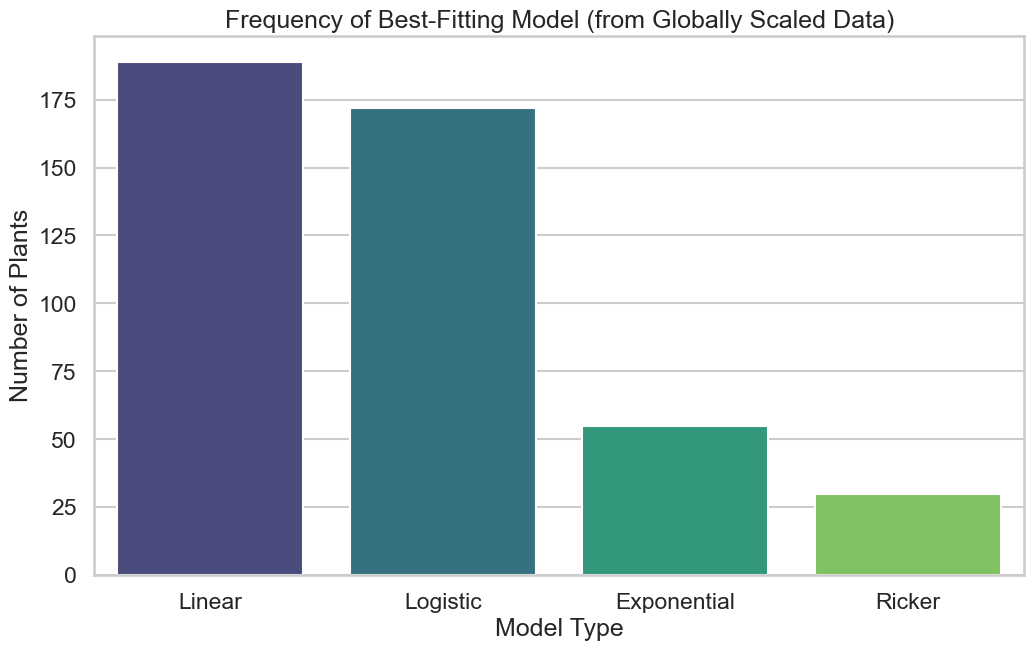

In [3]:
# Identify the AIC Weight columns
weight_cols = [col for col in results_df.columns if 'AIC_Weight' in col]

# For each row (plant), find the column name with the maximum AIC weight
results_df['Best_Model'] = results_df[weight_cols].idxmax(axis=1)

# Clean up the name for better plotting
results_df['Best_Model'] = results_df['Best_Model'].str.replace('_AIC_Weight', '')

# Plot the counts of the best model
plt.figure(figsize=(12, 7))
sns.countplot(data=results_df, x='Best_Model', order=results_df['Best_Model'].value_counts().index, palette='viridis')
plt.title('Frequency of Best-Fitting Model (from Globally Scaled Data)')
plt.xlabel('Model Type')
plt.ylabel('Number of Plants')
plt.show()

## 4.4 Analyze Trait Differences Between Genotypes

The parameters from our globally-scaled model fits (like the logistic `K`) represent the absolute magnitude of growth. Let's visualize the distribution of **Logistic Carrying Capacity (`K_optimal_log`)** and calculate its heritability.

C:\Users\katie\AppData\Local\Temp\ipykernel_16844\4237574760.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Plant Genotype', y='K_optimal_log', palette='coolwarm', order=sorted_order)


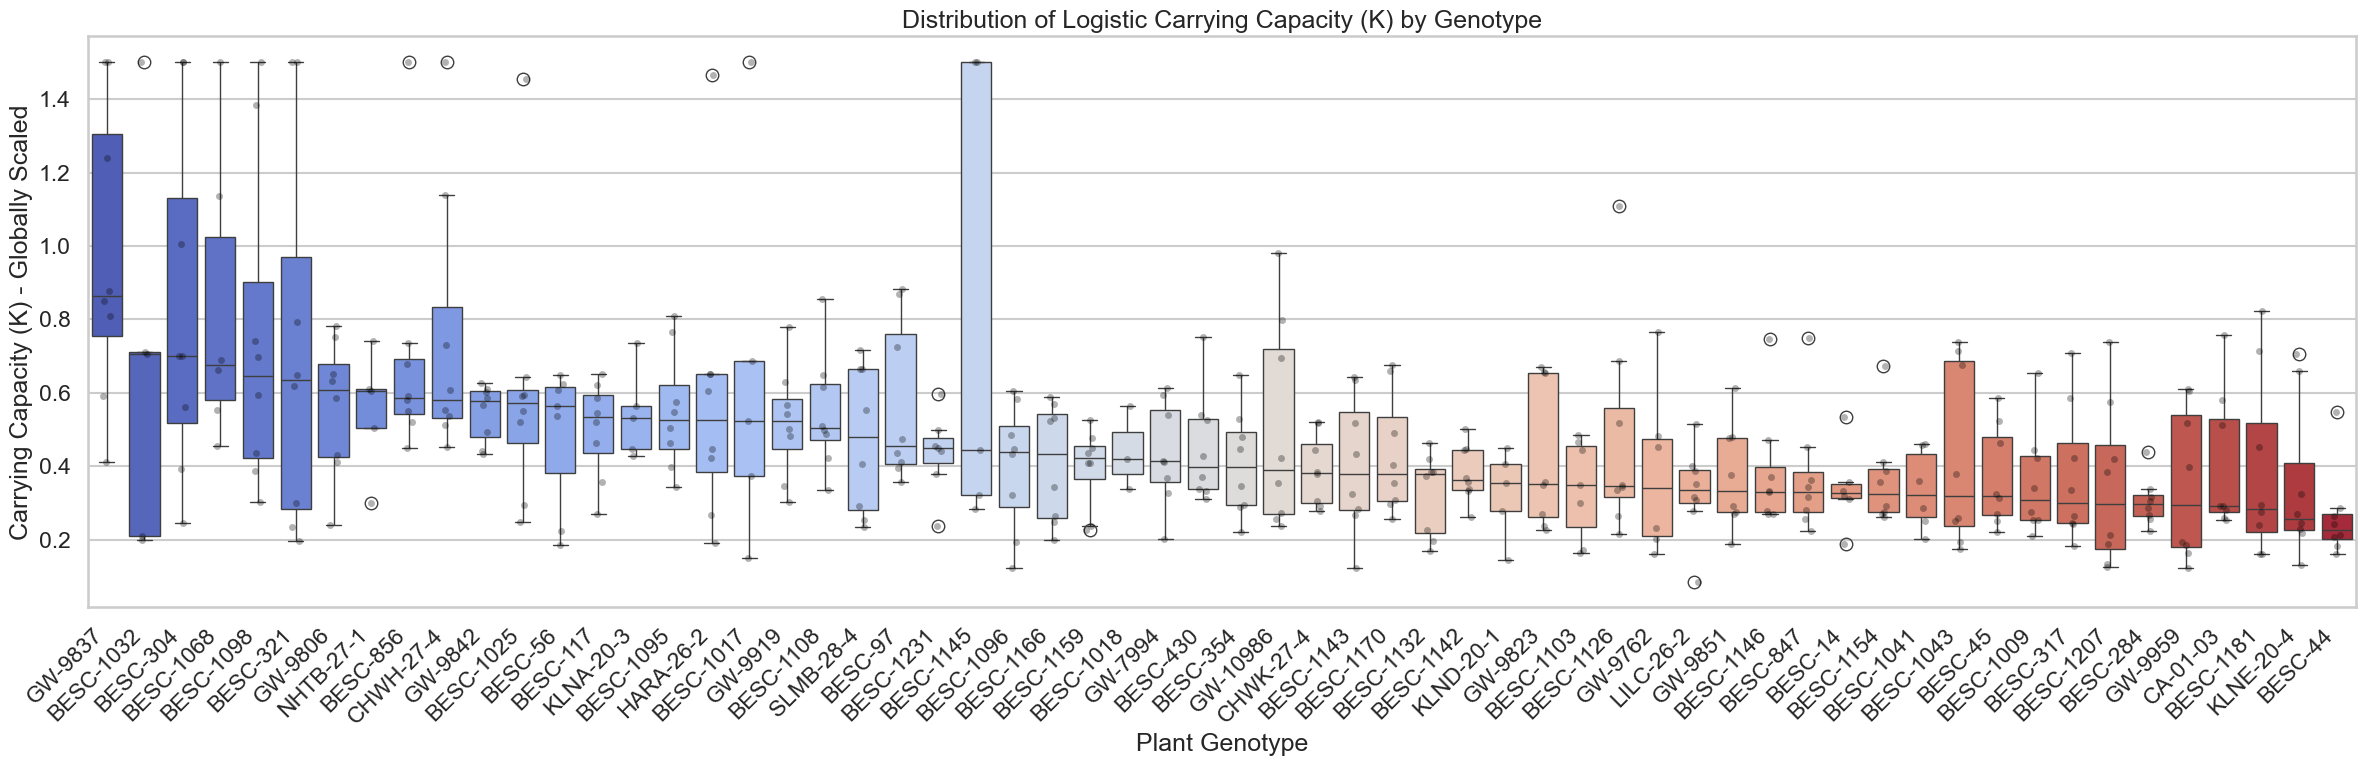

In [4]:
# Determine the sorting order by median value
medians = results_df.groupby('Plant Genotype')['K_optimal_log'].median()
sorted_order = medians.sort_values(ascending=False).index

# Increase the figure width to give labels more space
plt.figure(figsize=(24, 8))

# Create the boxplot
sns.boxplot(data=results_df, x='Plant Genotype', y='K_optimal_log', palette='coolwarm', order=sorted_order)
sns.stripplot(data=results_df, x='Plant Genotype', y='K_optimal_log', color='black', alpha=0.3, order=sorted_order)

plt.title('Distribution of Logistic Carrying Capacity (K) by Genotype')
plt.ylabel('Carrying Capacity (K) - Globally Scaled')
plt.xlabel('Plant Genotype')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4.5 Heritability Analysis ($H^2$)

This is the final and most important analysis. We'll calculate the **broad-sense heritability ($H^2$)** for our new traits (the model parameters). This tells us what proportion of the variation in a trait is due to genetic differences between the genotypes.

We will use our `calculate_heritability` function, which performs an ANOVA under the hood to estimate the variance components.

In [5]:
# Define the trait columns and their human-readable labels
trait_cols = [
    'k_optimal_linear', 'K_optimal_log', 'r_optimal_log', 
    'm_optimal_ricker'
]
trait_labels = {
    'k_optimal_linear': 'Linear Growth Rate (k)',
    'K_optimal_log': 'Logistic Carrying Capacity (K)',
    'r_optimal_log': 'Logistic Growth Rate (r)',
    'm_optimal_ricker': 'Ricker Peak Biomass (m)'
}

# Run the heritability analysis
heritability_summary_df = calculate_heritability(results_df, trait_cols, trait_labels)

print("--- Broad-Sense Heritability (H²) for Derived Traits ---")
print(heritability_summary_df.to_string(index=False))

--- Broad-Sense Heritability (H²) for Derived Traits ---
                         Trait  MS Genotype  MS Error  n_r  Var(G)  Var(E)  Var(P)    H²
        Linear Growth Rate (k)       0.0001    0.0000 7.16  0.0000  0.0000  0.0000 0.510
Logistic Carrying Capacity (K)       0.1748    0.0610 7.16  0.0159  0.0610  0.0768 0.207
      Logistic Growth Rate (r)       0.0101    0.0061 7.16  0.0006  0.0061  0.0067 0.085
       Ricker Peak Biomass (m)       0.0878    0.0293 7.16  0.0082  0.0293  0.0374 0.218


## Heritability Analysis for Balanced Design (8 Replicates)

Finally, as a sensitivity check, we will re-calculate the heritability on a subset of the data that has a **perfectly balanced design**.

We will:
1.  Filter the data to only include genotypes that have exactly **8 replicates**.
2.  Use a heritability function that calculates `n_r` using the **arithmetic mean**, which is appropriate for this balanced subset.

In [6]:
# --- Heritability Analysis for Balanced Design (8 Replicates) on Model Parameters ---

# --- Step 1: Filter for genotypes with exactly 8 replicates ---

# Count the number of unique plants per genotype from the ORIGINAL, complete dataframe
replicate_counts = merged_df.drop_duplicates(subset='Plant Info')['Plant.Genotype'].value_counts()

# Get the list of genotypes that have exactly 8 replicates
genotypes_with_8_reps = replicate_counts[replicate_counts == 8].index

# Create a new, filtered dataframe from the main results_df (which contains the parameters)
balanced_df = results_df[results_df['Plant Genotype'].isin(genotypes_with_8_reps)]

print(f"Found {len(genotypes_with_8_reps)} genotypes with exactly 8 replicates.")
print(f"The new balanced dataframe for analysis has {len(balanced_df)} total plants.")


# --- Step 2: Calculate heritability on the balanced subset using the ARITHMETIC mean function ---
print("\n--- Heritability for Model Parameters (Balanced Design, n=8) ---")

# Define the model parameter traits and their labels
trait_cols_params = [
    'k_optimal_linear', 'K_optimal_log', 'r_optimal_log', 
    'm_optimal_ricker'
]
trait_labels_params = {
    'k_optimal_linear': 'Linear Growth Rate (k)',
    'K_optimal_log': 'Logistic Carrying Capacity (K)',
    'r_optimal_log': 'Logistic Growth Rate (r)',
    'm_optimal_ricker': 'Ricker Peak Biomass (m)'
}

# Use the 'calculate_heritability_arithmetic' function on the balanced parameter data
heritability_summary_balanced_params = calculate_heritability_arithmetic(balanced_df, trait_cols_params, trait_labels_params)

# Display the results
print(heritability_summary_balanced_params.to_string(index=False))

Found 46 genotypes with exactly 8 replicates.
The new balanced dataframe for analysis has 368 total plants.

--- Heritability for Model Parameters (Balanced Design, n=8) ---
                         Trait  MS Genotype  MS Error  n_r  Var(G)  Var(E)  Var(P)    H²
        Linear Growth Rate (k)       0.0001    0.0000  8.0  0.0000  0.0000  0.0000 0.508
Logistic Carrying Capacity (K)       0.1796    0.0556  8.0  0.0155  0.0556  0.0711 0.218
      Logistic Growth Rate (r)       0.0106    0.0055  8.0  0.0006  0.0055  0.0061 0.105
       Ricker Peak Biomass (m)       0.0956    0.0284  8.0  0.0084  0.0284  0.0368 0.229


### 4.6 Conclusion

From the heritability table, we can draw conclusions about which aspects of plant growth are most strongly influenced by genetics in this experiment. Traits with a higher $H^2$ value (e.g., > 0.5) are considered to have a strong genetic component, making them good candidates for further study or breeding programs.

This concludes the analysis workflow.

--- Visualizing Final Area ---


C:\Users\katie\AppData\Local\Temp\ipykernel_16844\4168418780.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_with_final_area, x='Plant Genotype', y='Final_Area', palette='coolwarm', order=sorted_order_final)


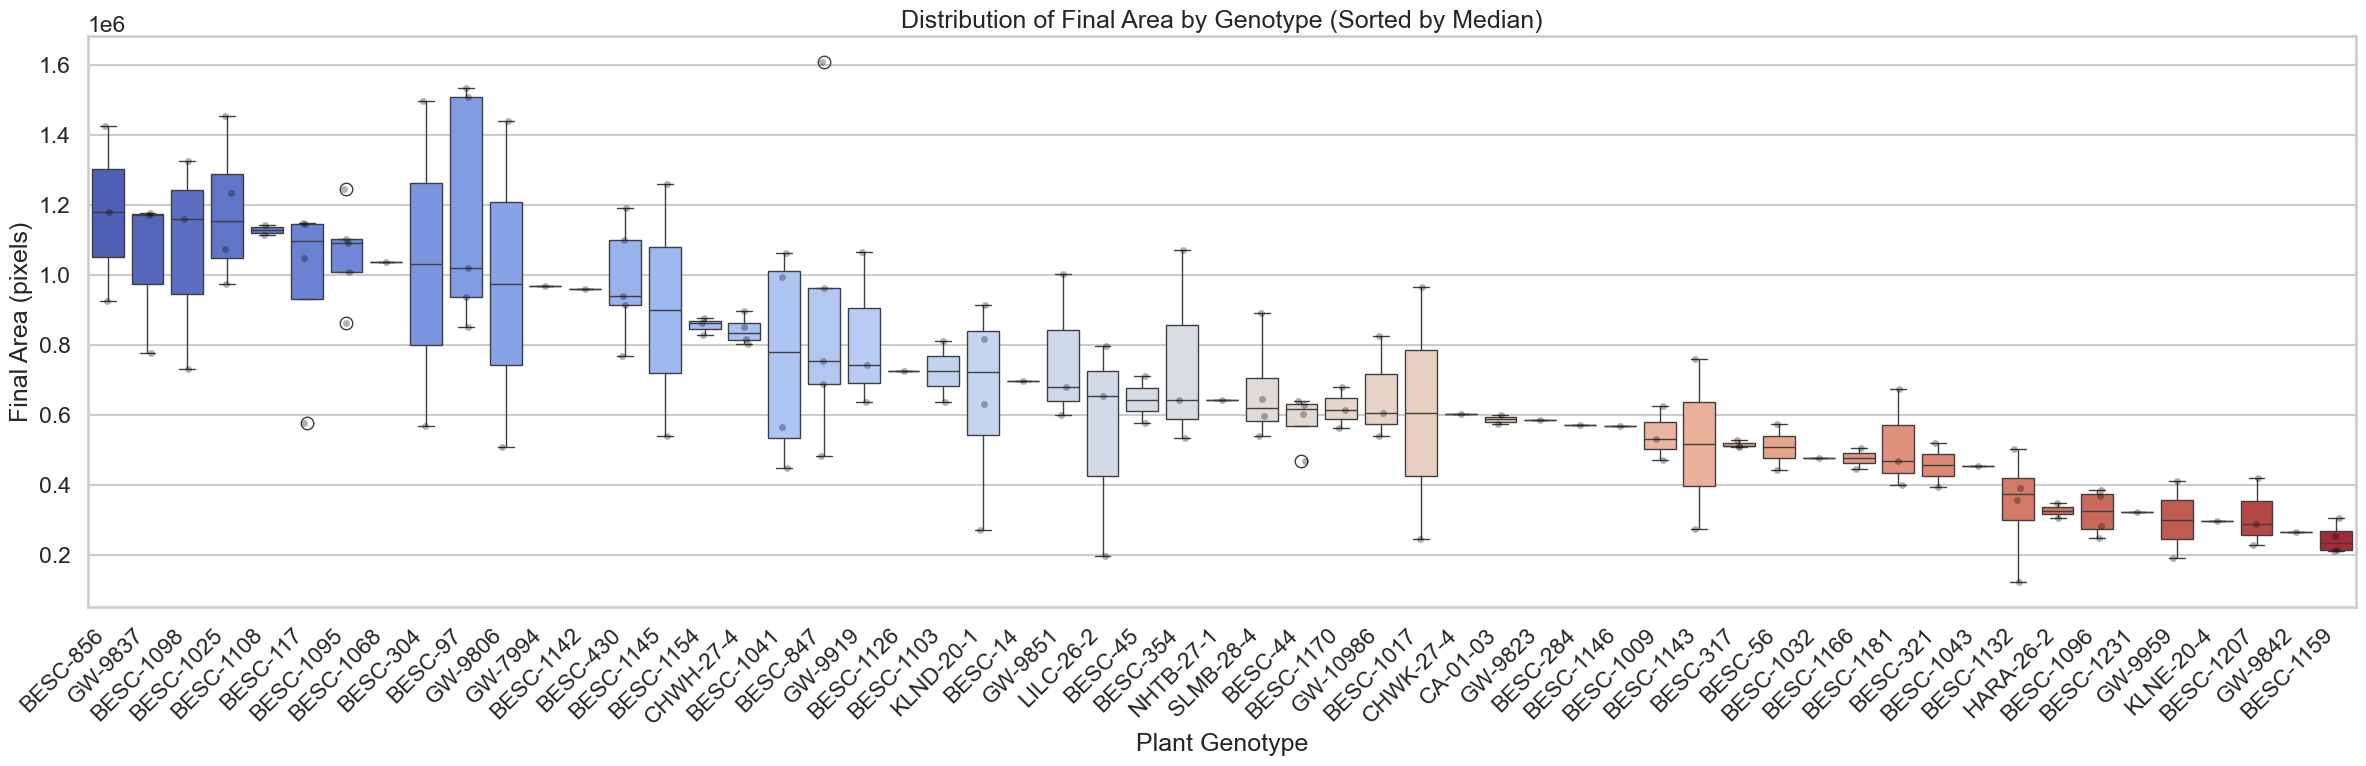


--- Heritability of Final Area ---
     Trait  MS Genotype     MS Error  n_r       Var(G)       Var(E)       Var(P)    H²
Final Area 1.917044e+11 5.779185e+10  1.9 7.040198e+10 5.779185e+10 1.281938e+11 0.549


In [7]:
# Find the last day data was collected
last_day = merged_df['Date'].max()

# Filter the original dataframe to get data from only the last day
final_day_data = merged_df[merged_df['Date'] == last_day]

# Calculate the mean area for each plant on that day
final_area_per_plant = final_day_data.groupby('Plant Info')['area'].mean().reset_index()
final_area_per_plant = final_area_per_plant.rename(columns={'area': 'Final_Area'})

# Merge this new trait into our main results dataframe
results_with_final_area = pd.merge(results_df, final_area_per_plant, on='Plant Info')

# --- 1. Visualize the Final Area by Genotype (Sorted) ---
print("--- Visualizing Final Area ---")

# Determine the sorting order by median value
medians_final = results_with_final_area.groupby('Plant Genotype')['Final_Area'].median()
sorted_order_final = medians_final.sort_values(ascending=False).index

plt.figure(figsize=(24, 8))
sns.boxplot(data=results_with_final_area, x='Plant Genotype', y='Final_Area', palette='coolwarm', order=sorted_order_final)
sns.stripplot(data=results_with_final_area, x='Plant Genotype', y='Final_Area', color='black', alpha=0.3, order=sorted_order_final)
plt.title('Distribution of Final Area by Genotype (Sorted by Median)')
plt.ylabel('Final Area (pixels)')
plt.xlabel('Plant Genotype')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 2. Calculate the Heritability of Final Area ---
print("\n--- Heritability of Final Area ---")
heritability_summary_final = calculate_heritability(results_with_final_area, ['Final_Area'], {'Final_Area': 'Final Area'})
print(heritability_summary_final.to_string(index=False))